<a href="https://colab.research.google.com/github/momoinu/Project-2/blob/master/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up

In [ ]:
!pip install feature_engine
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew #for some statistics

# importing alll the necessary packages to use the various classification algorithms
from sklearn.linear_model import LogisticRegression  # for Logistic Regression algorithm
from sklearn.model_selection import train_test_split #to split the dataset for training and testing
from sklearn.neighbors import KNeighborsClassifier  # for K nearest neighbours
from sklearn import svm  #for Support Vector Machine (SVM) Algorithm
from sklearn import metrics #for checking the model accuracy
from sklearn.metrics import mean_squared_error #for checking the model accuracy
from sklearn.tree import DecisionTreeClassifier #for using Decision Tree Algoithm
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from feature_engine import categorical_encoders as ce
from sklearn.preprocessing import LabelEncoder
import sklearn
import xgboost as xgb
import lightgbm as lgb

## Read data and preprocessing

In [ ]:
train_data = pd.read_csv('/content/drive/My Drive/housing_price/data/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/housing_price/data/test.csv')
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
num_cols = [col for col in train_data.columns if train_data[col].dtype in ["int64", "float64"] ]
cat_cols = [col for col in train_data.columns if train_data[col].dtype in ["object"]]

### Eliminate noise

In [ ]:
importance_cols = ['GrLivArea', 'BsmtFinSF1', 'LotArea', 'Neighborhood',
                   'TotalBsmtSF', 'GarageArea', 'LotFrontage', 'YearBuilt',
                   '1stFlrSF']
fig, axarr = plt.subplots(5, 2, figsize = (25, 30))
for (i,col) in enumerate(importance_cols):
    train_data.plot.scatter(
        x=col, 
        y="SalePrice", 
        ax=axarr[i//2][i%2]
    )
plt.savefig('noise_before.png')
# plt.show()
plt.gcf().clear()

<Figure size 1800x2160 with 0 Axes>

In [ ]:
# drop outliers
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index)
train_data = train_data.drop(train_data[(train_data['BsmtFinSF1']>3000)].index)
train_data = train_data.drop(train_data[(train_data['LotArea']>120000)].index)
train_data = train_data.drop(train_data[(train_data['GarageArea']>1200) & (train_data['SalePrice']<300000)].index)
train_data = train_data.drop(train_data[(train_data['TotalBsmtSF']>6000)].index)
train_data = train_data.drop(train_data[(train_data['LotFrontage']>300)].index)
train_data = train_data.drop(train_data[(train_data['1stFlrSF']>4000)].index)


In [ ]:
fig, axarr = plt.subplots(5, 2, figsize = (25, 30))
for (i,col) in enumerate(importance_cols):
    train_data.plot.scatter(
        x=col, 
        y="SalePrice", 
        ax=axarr[i//2][i%2]
    )
plt.savefig('noise_after.png')
# plt.show()
plt.gcf().clear()

<Figure size 1800x2160 with 0 Axes>

### Concat train data & test data
*Now* let's concat train data and test data, and save a copy of SalePrice and Id :

In [ ]:
# data preprocessing
Id = test_data['Id']
train_y = train_data.SalePrice.values
print(train_y)
all_data = pd.concat((train_data, test_data), sort=False).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))
# drop id
all_data = all_data.drop('Id', axis=1)
all_data.head(5)

[208500 181500 223500 ... 266500 142125 147500]
all_data size is : (2910, 80)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


### Xóa bỏ các feature với lượng missing > 20%

In [ ]:
# drop NAN that missing ratio is above a certain threshold
missing_data = all_data.isnull().sum()
missing_data = missing_data.drop(missing_data[missing_data == 0].index)
missing_ratio = missing_data / len(all_data) * 100

all_data = all_data.drop(missing_ratio[missing_ratio.values > 40].index, axis=1)
# all_data = all_data.drop(missing_data[missing_data.iloc[:] > 0].index, axis=1)
missing_data = all_data.isnull().sum()
missing_data = missing_data.drop(missing_data[missing_data == 0].index)
missing_ratio = missing_data / len(all_data) * 100
missing_ratio.to_csv('missing.csv')
print(missing_ratio)
all_data

MSZoning         0.137457
LotFrontage     16.597938
Utilities        0.068729
Exterior1st      0.034364
Exterior2nd      0.034364
MasVnrType       0.824742
MasVnrArea       0.790378
BsmtQual         2.783505
BsmtCond         2.817869
BsmtExposure     2.817869
BsmtFinType1     2.714777
BsmtFinSF1       0.034364
BsmtFinType2     2.749141
BsmtFinSF2       0.034364
BsmtUnfSF        0.034364
TotalBsmtSF      0.034364
Electrical       0.034364
BsmtFullBath     0.068729
BsmtHalfBath     0.068729
KitchenQual      0.034364
Functional       0.068729
GarageType       5.395189
GarageYrBlt      5.463918
GarageFinish     5.463918
GarageCars       0.034364
GarageArea       0.034364
GarageQual       5.463918
GarageCond       5.463918
SaleType         0.034364
dtype: float64


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,0,6,2006,WD,Normal
2906,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,0,4,2006,WD,Abnorml
2907,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,0,9,2006,WD,Abnorml
2908,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,Y,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,80,32,0,0,0,0,700,7,2006,WD,Normal


### Xử lý missing data và loại bỏ feature yếu


In [ ]:
drop_cols = []
drop_cols = ['Street', 'MiscVal', 'PoolArea', 'Condition2', 'Utilities',
             'Heating', 'PavedDrive', 'Electrical', 'BsmtHalfBath', 'GarageCond',
             'GarageFinish', 'ExterCond', 'HeatingQC', 'GarageQual', 'BldgType',
            #  'KitchenAbvGr', 'BsmtCond', 'BsmtFinType2', 'RoofMatl', 'LandSlope',
            #  '3SsnPorch', 'LowQualFinSF', 'LandContour', 'RoofStyle', 'SaleType',
            #  'CentralAir', 'HouseStyle', 'BsmtFullBath', 'LotShape', 'HalfBath',
            #  'KitchenQual', 'MSZoning', 'Exterior2nd', 'BsmtFinSF2', 'BsmtFinType1',
            #  'Foundation', 'FullBath', 'LotConfig', 'MasVnrType', 'BedroomAbvGr',
             ]
fill_common_case = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                    'Electrical', 'KitchenQual', 'Functional', 'SaleType']
fill_none_case = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                  'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
fill_zero_case = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 
                  'BsmtHalfBath', 'MasVnrArea', 'GarageYrBlt', 'GarageCars', 'GarageArea']

In [ ]:
# LotFrontage has more missing value
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
# These features, we just fill them with common case
for col in fill_common_case:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

#in these features, NAN means none
for col in fill_none_case:
    all_data[col] = all_data[col].fillna('None')

#in these features, NAN means 0
for col in fill_zero_case:
    all_data[col] = all_data[col].fillna(0)
    
# These features are useless, drop them
all_data = all_data.drop(columns=drop_cols, axis=1)

all_data

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Reg,Lvl,Inside,Gtl,CollgCr,Norm,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,Y,856,854,0,1710,1.0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,2.0,548.0,0,61,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Reg,Lvl,FR2,Gtl,Veenker,Feedr,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,Y,1262,0,0,1262,0.0,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,2.0,460.0,298,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,IR1,Lvl,Inside,Gtl,CollgCr,Norm,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,Y,920,866,0,1786,1.0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,2.0,608.0,0,42,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,IR1,Lvl,Corner,Gtl,Crawfor,Norm,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,Y,961,756,0,1717,1.0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,3.0,642.0,0,35,272,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,IR1,Lvl,FR2,Gtl,NoRidge,Norm,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,Y,1145,1053,0,2198,1.0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,3.0,836.0,192,84,0,0,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,160,RM,21.0,1936,Reg,Lvl,Inside,Gtl,MeadowV,Norm,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,Y,546,546,0,1092,0.0,1,1,3,1,TA,5,Typ,0,None,0.0,0.0,0.0,0,0,0,0,0,6,2006,WD,Normal
2906,160,RM,21.0,1894,Reg,Lvl,Inside,Gtl,MeadowV,Norm,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,Y,546,546,0,1092,0.0,1,1,3,1,TA,6,Typ,0,CarPort,1970.0,1.0,286.0,0,24,0,0,0,4,2006,WD,Abnorml
2907,20,RL,160.0,20000,Reg,Lvl,Inside,Gtl,Mitchel,Norm,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,Y,1224,0,0,1224,1.0,1,0,4,1,TA,7,Typ,1,Detchd,1960.0,2.0,576.0,474,0,0,0,0,9,2006,WD,Abnorml
2908,85,RL,62.0,10441,Reg,Lvl,Inside,Gtl,Mitchel,Norm,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,Y,970,0,0,970,0.0,1,0,3,1,TA,6,Typ,0,None,0.0,0.0,0.0,80,32,0,0,0,7,2006,WD,Normal


### Xử lý data dạng categorical bằng LabelEncoder

In [ ]:
# num_cols = [col for col in all_data.columns if all_data[col].dtype in ["int64", "float64"] ]
# cat_cols = [col for col in all_data.columns if all_data[col].dtype in ["object"]]

# for col in cat_cols:
#     all_data[col] = all_data[col].astype(str)

# # Label-Encoding 
# lbl = LabelEncoder()
# for col in cat_cols:
#     # Implement LE
#     lbl.fit(all_data[col].tolist())
#     all_data[col] = lbl.transform(all_data[col])
# all_data.head(5)

### Xử lý data dạng categorical bằng One-Hot-Encoder

In [ ]:
all_data = pd.get_dummies(all_data)
all_data.head(5)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,...,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,CentralAir_N,CentralAir_Y,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,2,2008,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,5,2007,0,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,9,2008,0,0,0,1,0,1,0,...,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,2,2006,0,0,0,1,0,1,0,...,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,12,2008,0,0,0,1,0,1,0,...,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


## Training


### Split to train and test data :

In [ ]:
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
# train, test = train_test_split(all_data, test_size=0.4998)
train = all_data[:ntrain]
test = all_data[ntrain:]
train_x = train
print(train_x.shape[0], train_y.shape[0])


1451 1451


### Validation model

In [ ]:
# seeds = range(30)

# n_folds = 5
# scores = []
# for seed in seeds:
#     kf = KFold(n_folds, shuffle=True, random_state=seed)
#     model = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                                 learning_rate=0.05, n_estimators=720,
#                                 max_bin = 55, bagging_fraction = 0.8,
#                                 bagging_freq = 5, feature_fraction = 0.2319,
#                                 feature_fraction_seed=9, bagging_seed=9,
#                                 min_data_in_leaf =6, min_sum_hessian_in_leaf = 11 )
#     # rmse= np.sqrt(-cross_val_score(model, train_x, train_y, scoring="neg_mean_square_error", cv = kf))
#     rmse= -cross_val_score(model, train_x, train_y, scoring="neg_mean_absolute_error", cv = kf)
#     scores.append(rmse)
# score_mean = []
# score_std = []
# for score in scores:
#     score_mean.append(score.mean())
#     score_std.append(score.std())
# print(sum(score_mean)/len(seeds))
# print(sum(score_std)/len(seeds))

### Training

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=0)
    # rmse= np.sqrt(-cross_val_score(model, train_x, train_y, scoring="neg_mean_square_error", cv = kf))
    rmse= -cross_val_score(model, train_x, train_y, scoring="neg_mean_absolute_error", cv = kf)
    return(rmse)

model = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                        learning_rate=0.05, n_estimators=720,
                        max_bin = 55, bagging_fraction = 0.8,
                        bagging_freq = 5, feature_fraction = 0.2319,
                        feature_fraction_seed=9, bagging_seed=9,
                        min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

score = rmsle_cv(model)
print(score)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[14536.52500349 13620.36877485 15090.99494568 14523.33538986
 12976.32143444]
LGBM score: 14149.5091 (752.6329)



In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))



**Train the selected model :**

In [ ]:
model.fit(train_x, train_y, verbose=1)
train_prediction = model.predict(train)
print(rmsle(train_y, train_prediction))

12601.047197162188


### Feature importance

In [ ]:
from matplotlib.pyplot import figure
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = train_x.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

figure(num=None, figsize=(20, 30))
    
g = sns.barplot(y=feature_importances.index,x = feature_importances.importance , orient='h')
g.set_xlabel("Coefficient",fontsize=14)
g.set_ylabel("Features",fontsize=14)
g.tick_params(labelsize=12)
g.set_title("Feature importance", fontsize=16)

plt.tight_layout()
plt.savefig("feature_importance.png")
# plt.show()
plt.gcf().clear()

<Figure size 1440x2160 with 0 Axes>

### Learning curve

<Figure size 432x288 with 0 Axes>

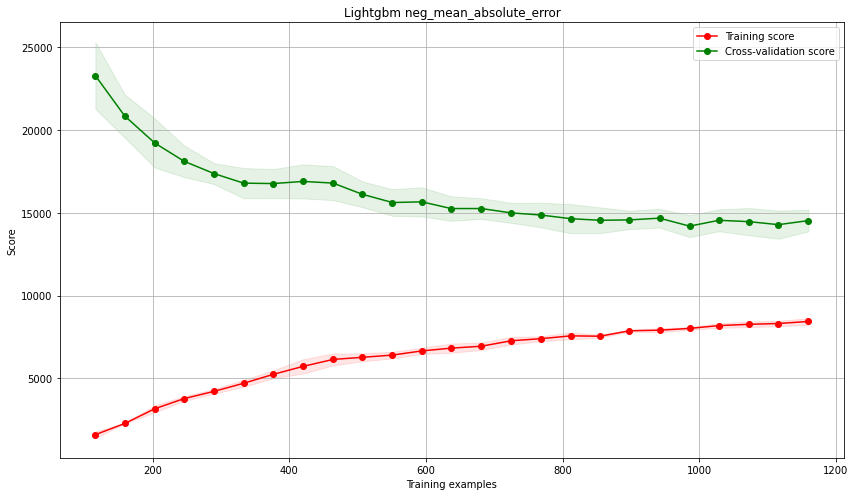

<Figure size 432x288 with 0 Axes>

In [ ]:
def plot_learning_curves(scoring_type, estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 25)):
    
    """Generate a simple plot of the test and training learning curve"""
    %matplotlib inline
    
    plt.figure(1)
    fig, axes = plt.subplots(figsize=(12, 7))

    
    title = title + " " + scoring_type
    axes.set_title(title)

    if ylim is not None:
        axes.set_ylim(*ylim)

    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator,
            X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
            scoring=scoring_type)

    if scoring_type == "neg_mean_squared_error" or scoring_type == "neg_mean_absolute_error": 
        train_scores = (-train_scores)
        test_scores = (-test_scores)

    

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    axes.grid()

    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    axes.legend(loc="best")


    plt.tight_layout()
    plt.savefig("curve.png")
    plt.show()
    plt.gcf().clear()

plot_learning_curves("neg_mean_absolute_error", model, 'Lightgbm', train_x, train_y, cv=5)

### Predict for test data

In [ ]:
prediction = model.predict(test.values)
print(prediction)
submission = pd.DataFrame({'Id': Id, 'SalePrice': prediction})
submission.to_csv('submission.csv', index=False)

[126810.71278054 162624.26211229 183656.14736754 ... 176672.11260594
 125398.03182786 208952.35549183]
